In [1]:
from typing import Callable, Tuple
import numpy as np
import sympy
from sympy import diff, Symbol, sin, cos, vector, exp, Eq, solve, simplify,lambdify
from sympy.physics.vector import dynamicsymbols
from scipy.integrate._ivp.ivp import solve_ivp
from scipy.integrate import odeint
from scipy.constants import g as grav
import matplotlib.pyplot as plt

In [2]:
class Tmp(object):
    def __init__(self):
        super().__init__()

class Settings(object):
    def __init__(self):
        super().__init__()
        self.mg = 0
        self.proportions = {
            "OK":{"l":0.4575,"m":0.63},
            "UK":{"l":0.5425,"m":0.37}
        }
        self.l = 2
        self.m = 90
        self.h = 60
        self.b = 35e-2
        self.c_w = 0.78
        self.roh = 1.2
        self.v_0 = 2
        self.alpha0 = np.array([np.radians(0),np.radians(179)])
        self.alpha0_p = np.array([-80*np.pi/180,-10*np.pi/180])
        self.phi0 = 30
        
    def l_1(self):
        return self.proportions["OK"]["l"]*self.l
    def l_2(self):
        return self.proportions["UK"]["l"]*self.l
    def m_1(self):
        return self.proportions["OK"]["m"]*self.m
    def m_2(self):
        return self.proportions["UK"]["m"]*self.m
    def mass(self):
        return self.m_1()+self.m_2()
    def s_1(self):
        return self.l_1()/2
    def s_2(self):
        return self.l_2()/2
    def j_1(self):
        return (1/12)*np.power(self.l_1(),2)*self.m_1()
    def j_2(self):
        return (1/12)*np.power(self.l_2(),2)*self.m_2()
    def kappa(self,alpha) -> float:
        """Computed kappa
        Returns:
            float
        """
        return (1 / 2) * self.roh * self.c_w * self.b * np.absolute(np.sin(np.radians(alpha)))*self.l_1()

class DGL(object):
    def __init__(self):
        super().__init__()
        self.alpha1 = None
        self.alpha2 = None


class Events(object):
    """Events Objekt. Hält alle event funktionen.
    """
    def get_events(self) -> Tuple[Callable]:
        """Gibt alle Eventfunktionen zurück

        Returns:
            Tuple[Callable]: Event Funktionen als Tuple
        """
        return tuple([x for x in vars(self).values() if callable(x)])
        
        
temp = Tmp()
settings = Settings()
dgls = DGL()

In [3]:
alpha1 = dynamicsymbols('alpha1')
alpha2 = dynamicsymbols('alpha2')

In [4]:
alpha1_p = diff(alpha1, Symbol('t'))
alpha2_p = diff(alpha2, Symbol('t'))
alpha1_pp = diff(alpha1_p, Symbol('t'))
alpha2_pp = diff(alpha2_p, Symbol('t'))

In [5]:
s1 = Symbol('s1')
s2 = Symbol('s2')
m1 = Symbol("m1")
m2 = Symbol("m2")
m = m1+m2
g = Symbol("g")
j_1 = Symbol("j_1")
j_2 = Symbol("j_2")
M_G = Symbol("M_G")

a1_p = Symbol("a1_p")
a1_pp = Symbol("a1_pp")
a2_p = Symbol("a2_p")
a2_pp = Symbol("a2_pp")

l_m = Symbol("L_M")

In [6]:
# Ortsvektoren
w_f = np.array([0,0, -alpha1_p])
w_f_p = np.array([diff(w_f[i],Symbol('t')) for i in range(3)])
r_m_1_g = np.array([0,s1,0])
r_m_2_g = np.array([s2*sin(alpha2),s2*cos(alpha2),0])
r_m_1_g_p = np.array([diff(r_m_1_g[i],Symbol('t')) for i in range(3)])
r_m_2_g_p = np.array([diff(r_m_2_g[i],Symbol('t')) for i in range(3)])

r_m_g = (m1*r_m_1_g+m2*r_m_2_g)/m
r_m_g_p = np.array([diff(r_m_g[i],Symbol('t')) for i in range(3)])
r_m_g_pp = np.array([diff(r_m_g_p[i],Symbol('t')) for i in range(3)])

r_m_1_m = r_m_1_g-r_m_g
r_m_2_m = r_m_2_g-r_m_g
r_m_1_m_p = np.array([diff(r_m_1_m[i],Symbol('t')) for i in range(3)])
r_m_2_m_p = np.array([diff(r_m_2_m[i],Symbol('t')) for i in range(3)])

In [7]:
# v
v_m_1_g = r_m_1_g_p + np.cross(w_f,r_m_1_g)
v_m_2_g = r_m_2_g_p + np.cross(w_f,r_m_2_g)

v_m_1_m = r_m_1_m_p + np.cross(w_f,r_m_1_m)
v_m_2_m = r_m_2_m_p + np.cross(w_f,r_m_2_m)

v_m_g = r_m_g_p + np.cross(w_f,r_m_g)

In [8]:
# a
a_m = np.array([sin(alpha1)*g,-cos(alpha1)*g,0])
a_cor = 2 * np.cross(w_f,r_m_g_p)
a_rel = r_m_g_pp
a_f_1 = np.cross(w_f_p,r_m_g)+np.cross(w_f,np.cross(w_f,r_m_g))
a_g = a_m - a_f_1 - a_rel - a_cor

In [9]:
# Drall
L_1_m_1 = np.array([0,0,-j_1*alpha1_p])
L_2_m_2 = np.array([0,0,-j_2*(alpha1_p+alpha2_p)])

L_m = L_1_m_1 + np.cross(r_m_1_m,m1*v_m_1_m)+L_2_m_2 + np.cross(r_m_2_m,m2*v_m_2_m)
L_1_g = L_1_m_1 + np.cross(r_m_1_g,m1*v_m_1_g)
L_m_p = np.array([diff(L_m[i],Symbol('t')) for i in range(3)])
L_1_g_p = np.array([diff(L_1_g[i],Symbol('t')) for i in range(3)])

L_m = simplify(Eq(Symbol("L_M"),L_m[2]))
L_m

Eq(L_M, (-j_1*m1*Derivative(alpha1(t), t) - j_1*m2*Derivative(alpha1(t), t) - j_2*m1*Derivative(alpha1(t), t) - j_2*m1*Derivative(alpha2(t), t) - j_2*m2*Derivative(alpha1(t), t) - j_2*m2*Derivative(alpha2(t), t) - m1*m2*s1**2*Derivative(alpha1(t), t) + 2*m1*m2*s1*s2*cos(alpha2(t))*Derivative(alpha1(t), t) + m1*m2*s1*s2*cos(alpha2(t))*Derivative(alpha2(t), t) - m1*m2*s2**2*Derivative(alpha1(t), t) - m1*m2*s2**2*Derivative(alpha2(t), t))/(m1 + m2))

In [10]:
# Drallsatz in M
DS_M_L = np.array([0,0,0])
DS_M_R = L_m_p
DS_M = simplify(Eq(DS_M_L[2],DS_M_R[2])) #Eq(lhs, rhs)
DS_M

Eq((-j_1*m1*Derivative(alpha1(t), (t, 2)) - j_1*m2*Derivative(alpha1(t), (t, 2)) - j_2*m1*Derivative(alpha1(t), (t, 2)) - j_2*m1*Derivative(alpha2(t), (t, 2)) - j_2*m2*Derivative(alpha1(t), (t, 2)) - j_2*m2*Derivative(alpha2(t), (t, 2)) - m1*m2*s1**2*Derivative(alpha1(t), (t, 2)) - 2*m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)*Derivative(alpha2(t), t) - m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha2(t), t)**2 + 2*m1*m2*s1*s2*cos(alpha2(t))*Derivative(alpha1(t), (t, 2)) + m1*m2*s1*s2*cos(alpha2(t))*Derivative(alpha2(t), (t, 2)) - m1*m2*s2**2*Derivative(alpha1(t), (t, 2)) - m1*m2*s2**2*Derivative(alpha2(t), (t, 2)))/(m1 + m2), 0)

In [11]:
# Drallsatz
FG = np.array([sin(alpha1)*m1*g, -cos(alpha1)*m1*g, 0])
DS_R = L_1_g_p + np.cross(w_f,L_1_g) + np.cross(r_m_1_g,m1*a_g)
DS_L = np.array([0,0,M_G]) + np.cross(r_m_1_g,FG)
DS = simplify(Eq(DS_L[2],DS_R[2])) #Eq(lhs, rhs)
DS

Eq(M_G - g*m1*s1*sin(alpha1(t)), -(m1*s1*(g*(m1 + m2)*sin(alpha1(t)) + m2*s2*sin(alpha2(t))*Derivative(alpha1(t), t)**2 + 2*m2*s2*sin(alpha2(t))*Derivative(alpha1(t), t)*Derivative(alpha2(t), t) + m2*s2*sin(alpha2(t))*Derivative(alpha2(t), t)**2 - m2*s2*cos(alpha2(t))*Derivative(alpha2(t), (t, 2)) - (m1*s1 + m2*s2*cos(alpha2(t)))*Derivative(alpha1(t), (t, 2))) + (j_1 + m1*s1**2)*(m1 + m2)*Derivative(alpha1(t), (t, 2)))/(m1 + m2))

In [12]:
# nach alpha1_pp und alpha2_pp und MG auflösen
solution1 = solve(DS_L-DS_R,alpha1_pp)
solution2 = solve(DS_M_L-DS_M_R,alpha2_pp)
solution3 = solve(DS_L-DS_R,M_G)

In [13]:
# Lösungsdictionary Keys
key_alpha1 = list(solution1.keys())[0]
key_alpha2 = list(solution2.keys())[0]
key_mg = list(solution3.keys())[0]

In [14]:
# alpha1_pp
alpha1_pp_alpha2_pp = simplify(Eq(alpha1_pp,solution1[key_alpha1]))
alpha1_pp_alpha2_pp

Eq(Derivative(alpha1(t), (t, 2)), (-M_G*m1 - M_G*m2 - m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)**2 - 2*m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)*Derivative(alpha2(t), t) - m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha2(t), t)**2 + m1*m2*s1*s2*cos(alpha2(t))*Derivative(alpha2(t), (t, 2)))/(j_1*m1 + j_1*m2 + m1*m2*s1**2 - m1*m2*s1*s2*cos(alpha2(t))))

In [15]:
# alpha2_pp
alpha2_pp_alpha1_pp = simplify(Eq(alpha2_pp,solution2[key_alpha2]))
alpha2_pp_alpha1_pp

Eq(Derivative(alpha2(t), (t, 2)), (j_1*m1*Derivative(alpha1(t), (t, 2)) + j_1*m2*Derivative(alpha1(t), (t, 2)) + j_2*m1*Derivative(alpha1(t), (t, 2)) + j_2*m2*Derivative(alpha1(t), (t, 2)) + m1*m2*s1**2*Derivative(alpha1(t), (t, 2)) + 2*m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)*Derivative(alpha2(t), t) + m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha2(t), t)**2 - 2*m1*m2*s1*s2*cos(alpha2(t))*Derivative(alpha1(t), (t, 2)) + m1*m2*s2**2*Derivative(alpha1(t), (t, 2)))/(-j_2*m1 - j_2*m2 + m1*m2*s1*s2*cos(alpha2(t)) - m1*m2*s2**2))

In [16]:
# solution for I in II for alpha1
alpha1_pp_solve = solve([alpha1_pp_alpha2_pp,alpha2_pp_alpha1_pp],(alpha1_pp,alpha2_pp))
key_alpha1_solve = list(alpha1_pp_solve.keys())[0]

In [17]:
# alpha1_pp
alpha1_pp_sol = simplify(Eq(alpha1_pp,alpha1_pp_solve[key_alpha1_solve]))
alpha1_pp_sol

Eq(Derivative(alpha1(t), (t, 2)), (-M_G*j_2*m1**2 - 2*M_G*j_2*m1*m2 - M_G*j_2*m2**2 + M_G*m1**2*m2*s1*s2*cos(alpha2(t)) - M_G*m1**2*m2*s2**2 + M_G*m1*m2**2*s1*s2*cos(alpha2(t)) - M_G*m1*m2**2*s2**2 - j_2*m1**2*m2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)**2 - 2*j_2*m1**2*m2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)*Derivative(alpha2(t), t) - j_2*m1**2*m2*s1*s2*sin(alpha2(t))*Derivative(alpha2(t), t)**2 - j_2*m1*m2**2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)**2 - 2*j_2*m1*m2**2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)*Derivative(alpha2(t), t) - j_2*m1*m2**2*s1*s2*sin(alpha2(t))*Derivative(alpha2(t), t)**2 + m1**2*m2**2*s1**2*s2**2*sin(2*alpha2(t))*Derivative(alpha1(t), t)**2/2 - m1**2*m2**2*s1*s2**3*sin(alpha2(t))*Derivative(alpha1(t), t)**2 - 2*m1**2*m2**2*s1*s2**3*sin(alpha2(t))*Derivative(alpha1(t), t)*Derivative(alpha2(t), t) - m1**2*m2**2*s1*s2**3*sin(alpha2(t))*Derivative(alpha2(t), t)**2)/(j_1*j_2*m1**2 + 2*j_1*j_2*m1*m2 + j_1*j_2*m2**2 + j_1*m1**2*m2*s2**2 + j_

In [18]:
m_g_sol = simplify(Eq(M_G,solution3[key_mg]))
m_g_sol

Eq(M_G, (-j_1*m1*Derivative(alpha1(t), (t, 2)) - j_1*m2*Derivative(alpha1(t), (t, 2)) - m1*m2*s1**2*Derivative(alpha1(t), (t, 2)) - m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)**2 - 2*m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha1(t), t)*Derivative(alpha2(t), t) - m1*m2*s1*s2*sin(alpha2(t))*Derivative(alpha2(t), t)**2 + m1*m2*s1*s2*cos(alpha2(t))*Derivative(alpha1(t), (t, 2)) + m1*m2*s1*s2*cos(alpha2(t))*Derivative(alpha2(t), (t, 2)))/(m1 + m2))

In [19]:
# substituieren der ersten ableitungen von alpha
didt_substitudes = [
    (alpha1_p,a1_p),
    (alpha2_p,a2_p),
]

# # substituieren der zweiten ableitungen von alpha
d2idt2_substitudes = [
    (diff(alpha1_p,Symbol("t")),a1_pp),
    (diff(alpha2_p,Symbol("t")),a2_pp)   
]

# # konstanten substituieren
substitudes = [
        (m1, settings.m_1()),
        (m2, settings.m_2()),
        (s1, settings.s_1()),
        (s2, settings.s_2()),
        (j_1,settings.j_1()),
        (j_2,settings.j_2()),
]
sub_alpha1_pp_sol = alpha1_pp_sol.rhs.subs(didt_substitudes+substitudes)
sub_alpha2_pp_alpha1_pp = alpha2_pp_alpha1_pp.rhs.subs(d2idt2_substitudes+didt_substitudes+substitudes)
sub_mg_sol = m_g_sol.rhs.subs(d2idt2_substitudes+didt_substitudes+substitudes)

sub_lm_sol = L_m.rhs.subs(didt_substitudes+substitudes)
sub_lm_sol_corr = sub_lm_sol.subs([(a2_p,0)])
L_m_corr = simplify(Eq(l_m,sub_lm_sol_corr))
solution_alpha1_l_m_corr = solve(L_m_corr.lhs-L_m_corr.rhs,a1_p)[0]
sub_lm_sol

10.4137133625*a1_p*cos(alpha2(t)) - 17.7879741375*a1_p + 5.20685668125*a2_p*cos(alpha2(t)) - 9.44105019375*a2_p

In [20]:
# Events
def hit_ground(t: np.ndarray, u: np.ndarray) -> float:
    """Event um das Auftreffen zum Zeitpunkt t zu erfassen.

    Args:
        t (ndarray): Zeitvektor
        u (ndarray): Vektor der Bewegungsgleichung

    Returns:
        float: Abstand r in y-Richtung
    """
    r, _ = np.split(u, 2)
    return r[1]

def closed(t:np.ndarray, u:np.ndarray)->float:
    a, _ = np.split(u, 2)
    a_2 = a[1]
    if a_2-np.radians(180)>np.radians(110):
        return a_2-np.radians(180)
    elif a_2<np.radians(20):
        return a_2
    return 100

closed.terminal = True
hit_ground.terminal = True

In [21]:
def drag_force(t, r, v):
    alpha, _ = np.split(temp.alpha_sol(t), 2)
    alpha1 = alpha[0]
    return  settings.kappa(alpha1)* np.linalg.norm(v)

In [22]:
# ivp dgl
def dgl_alpha(t: np.ndarray, u: np.ndarray) -> np.ndarray:
    alpha_, alpha_p_ = np.split(u, 2)

    alpha1_ = alpha_[0]
    alpha2_ = alpha_[1]
    alpha1_p_ = alpha_p_[0]
    alpha2_p_ = alpha_p_[1]
    
    if not t:
        mg = settings.mg
        temp.mg_sol = []
    else:
        mg = temp.mg

    # numpy functions
    f_a_1_pp = lambdify((a1_p,a2_p,alpha2, M_G), sub_alpha1_pp_sol, "numpy")
    f_a_2_pp = lambdify((a1_pp,a1_p,a2_p,alpha2), sub_alpha2_pp_alpha1_pp, "numpy")
    f_m_g_2_pp = lambdify((a1_pp,a2_pp,a1_p,a2_p,alpha2), sub_mg_sol, "numpy")
    f_l_m = lambdify((a1_p,a2_p,alpha2),sub_lm_sol,"numpy")
    f_alpha1_l_m_corr = lambdify((l_m,alpha2), solution_alpha1_l_m_corr, "numpy")
    
    a_1_pp = f_a_1_pp(alpha1_p_,alpha2_p_,alpha2_,mg)
    a_2_pp = f_a_2_pp(a_1_pp,alpha1_p_,alpha2_p_,alpha2_)
    m_g_grenz = f_m_g_2_pp(a_1_pp,0,alpha1_p_,0,alpha2_)

    if alpha2_<=0:
        if alpha2_p_ < 0:
            l_m_ = f_l_m(alpha1_p_,alpha2_p_,alpha2_)
            alpha1_p_ = f_alpha1_l_m_corr(l_m_,alpha2_)
            alpha2_p_ = 0
        if m_g_grenz<mg:
            mg = f_m_g_2_pp(a_1_pp,a_2_pp,alpha1_p_,alpha2_p_,alpha2_)
            
        a_1_pp = f_a_1_pp(alpha1_p_,alpha2_p_,alpha2_,mg)
        a_2_pp = f_a_2_pp(a_1_pp,alpha1_p_,alpha2_p_,alpha2_)
        
    if alpha2_>=np.radians(180):
        if alpha2_p_ > 0:
            l_m_ = f_l_m(alpha1_p_,alpha2_p_,alpha2_)
            alpha1_p_ = f_alpha1_l_m_corr(l_m_,alpha2_)
            alpha2_p_ = 0
        if m_g_grenz>mg:
            mg = f_m_g_2_pp(a_1_pp,a_2_pp,alpha1_p_,alpha2_p_,alpha2_)
            
        a_1_pp = f_a_1_pp(alpha1_p_,alpha2_p_,alpha2_,mg)
        a_2_pp = f_a_2_pp(a_1_pp,alpha1_p_,alpha2_p_,alpha2_)

    temp.mg = mg
    temp.mg_sol.append(mg)
    
    return np.concatenate([np.array([alpha1_p_,a_1_pp]),np.array([alpha2_p_,a_2_pp])])

In [23]:
# Differentialgleichung für Schwerpunktsgeschwindigkeit v_M
def dgl_sps(t, u):
    r, v = np.split(u, 2)
    drag_direction = np.array([-1,-1,0]) if v[1] else np.array([-1,1,0])
    f_drag: np.ndarray = drag_force(t,r,v) * drag_direction
    dvdt: np.ndarray = f_drag/settings.mass() + grav * np.array([0, -1, 0])
    return np.concatenate([v, dvdt])

In [24]:
# Anfangsbedingungen für Winkel alpha
u0_alpha = np.concatenate([settings.alpha0,settings.alpha0_p])
t0_alpha = [0,2]


In [25]:
# ODE45 Solver für Winkel alpha
res = solve_ivp(dgl_alpha,[0,2],u0_alpha,events=(closed), dense_output=True)
t_s = res.t
r_s = np.split(res.y, 2)
t = np.linspace(0, np.max(t_s), 1000)
alpha, alpha_p = np.split(res.sol(t), 2)

In [26]:
# Save solution in temp
temp.alpha_sol = res.sol

In [27]:
# Anfangsbedingungen für Schwerpunktsgeschwindigkeit v
r_0 = np.array([0,settings.h,0])
phi_0 = np.array([
    np.cos(np.radians(settings.phi0)),
    np.sin(np.radians(settings.phi0)),
    0
])
v_0 = settings.v_0 * phi_0
u0_sps = np.concatenate((r_0,v_0))

In [28]:
# ODE45 Solver für Schwerpunktsgeschwindigkeit
res_r = solve_ivp(dgl_sps, [0, np.inf], u0_sps, events=[hit_ground], dense_output=True)
t_s_sps = res_r.t
r_s_sps = np.split(res_r.y, 2)
t_sps = np.linspace(0, np.max(t_s_sps), 1000)
r, v = np.split(res_r.sol(t_sps), 2)

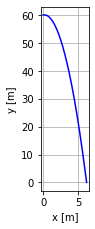

In [29]:
fig = plt.figure(figsize=(9, 6))
fig.set_tight_layout(1)
ax1 = fig.add_subplot(2, 1, 1)
# ax1.tick_params(labelbottom=False)
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")

ratio = 0.4
xleft, xright = ax1.get_xlim()
ybottom, ytop = ax1.get_ylim()
ax1.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

ax1.grid()
ax1.plot(r[0], r[1], "-b")

plt.show()

In [30]:
f"Höchste stelle: {np.max(r[1])} m und Sprungweite: {np.max(r[0])} m"

'Höchste stelle: 60.050980576441276 m und Sprungweite: 6.2323470564602275 m'

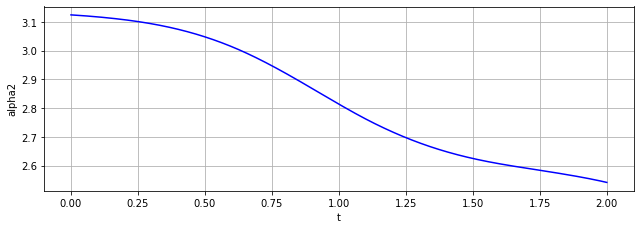

In [31]:
# deg_alpha2 =np.array([np.degrees(x) for x in alpha[1]])  
fig = plt.figure(figsize=(9, 6))
fig.set_tight_layout(1)
ax1 = fig.add_subplot(2, 1, 1)
# ax1.tick_params(labelbottom=False)
ax1.set_xlabel("t")
ax1.set_ylabel("alpha2")
ax1.grid()
ax1.plot(t, alpha[1], "-b")

In [32]:
# Rotationsmatrix
R = np.array([(cos(alpha2),sin(alpha2),0),(-sin(alpha2),cos(alpha2),0),(0,0,0)])
r_m_g_t = R * r_m_g
r_m_1_g_t = R * r_m_1_g
r_m_2_g_t = R * r_m_2_g

In [33]:
# Werte
rmg = np.array([[r_m_g_t[i] for i in range(3)] for _ in alpha[1]])
rm1g = np.array([[r_m_1_g_t[i] for i in range(3)] for _ in alpha[1]])
rm2g = np.array([[r_m_2_g_t[i] for i in range(3)] for _ in alpha[1]])

# # try:
for i,a in enumerate(alpha[1]):
    for j,r in enumerate(rmg[i]):
        for k,_ in enumerate(r):
            try:
                rmg[i][j][k] = rmg[i][j][k].subs([(m2,settings.m_2()),(m1,settings.m_1()),(s2,settings.s_2()),(s1,settings.s_1()),(alpha2,a)])
                rm1g[i][j][k] = rm1g[i][j][k].subs([(s1,settings.s_1()),(alpha2,a)])
                rm2g[i][j][k] = rm2g[i][j][k].subs([(s2,settings.s_2()),(alpha2,a)])
            except:
                pass